# ABS Quarterly Building Activity 8752

## Python set-up

In [1]:
# system imports
import textwrap

# analytic imports
import pandas as pd
import readabs as ra
from readabs import metacol as mc
from mgplot import seastrend_plot_finalise, line_plot_finalise, multi_start

# local imports
from abs_helper import get_abs_data

# pandas display settings
pd.options.display.max_rows = 999999
pd.options.display.max_columns = 999
pd.options.display.max_colwidth = 999

# Display charts in the notebook
SHOW = True
FILE_TYPE = "png"

## Get data from ABS

In [2]:
abs_dict, meta, source, _ = get_abs_data("8752.0")
plot_times = (0, -13)

Table 87520DO001_202506 has no 'Index' sheet.
Table 87520DO002_202506 has no 'Index' sheet.
Table 87520DO003_202506 has no 'Index' sheet.
Table 87520DO004_202506 has no 'Index' sheet.
Table 87520DO005_202506 has no 'Index' sheet.
Table 87520DO006_202506 has no 'Index' sheet.
Table 87520_activity has no 'Index' sheet.
Table Building Activity Average dwelling commencement times has no 'Index' sheet.
Table Building Activity Average dwelling completion times has no 'Index' sheet.
Table Building Activity Abandonment rates for new dwellings has no 'Index' sheet.


## Plot

### Headline charts

#### Core code

Note: generates some "Nothing selected" messages for the under construction block.

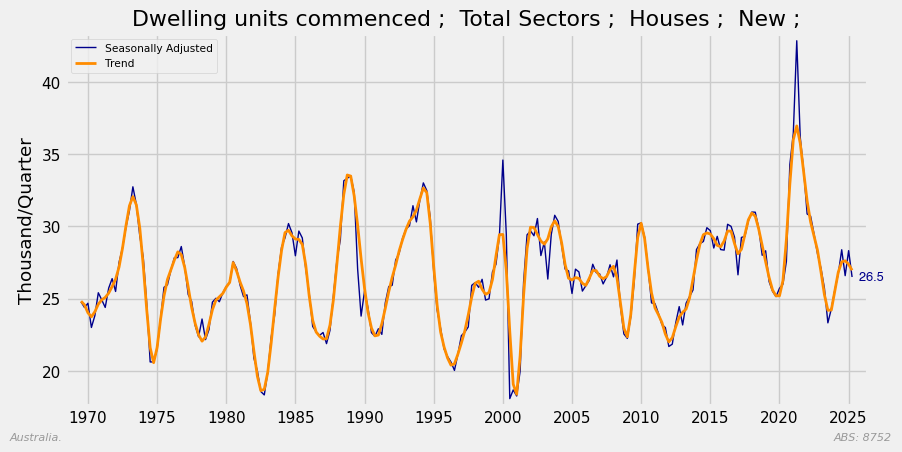

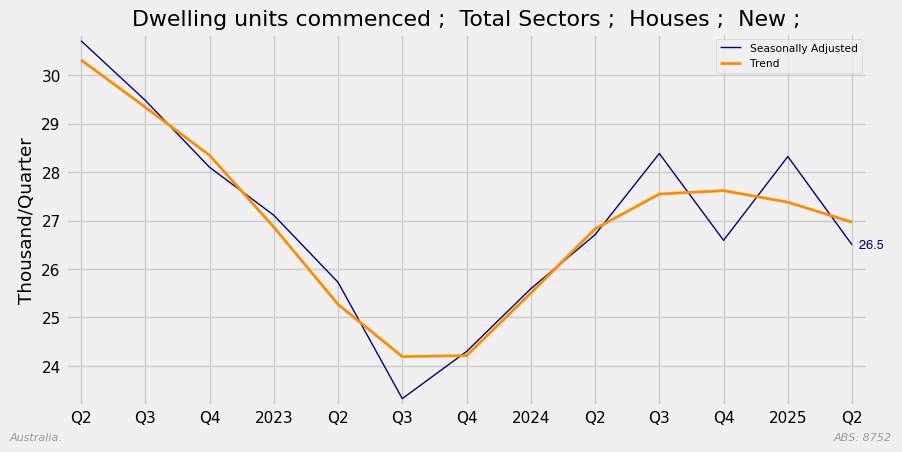

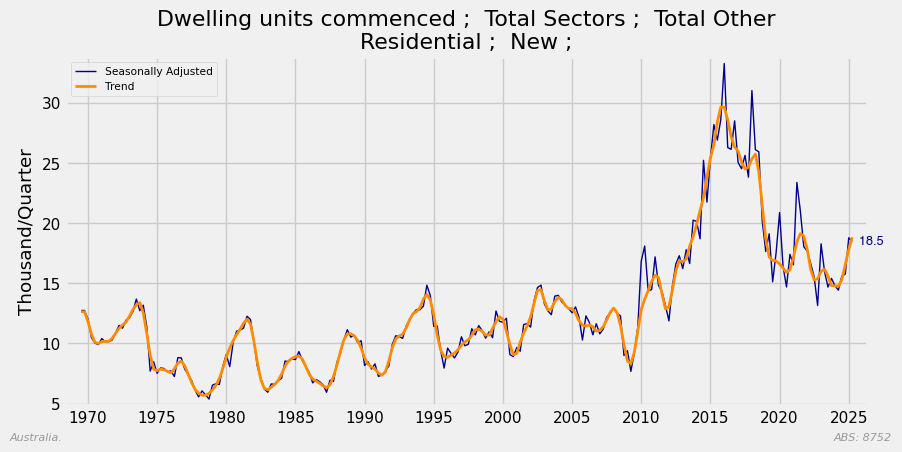

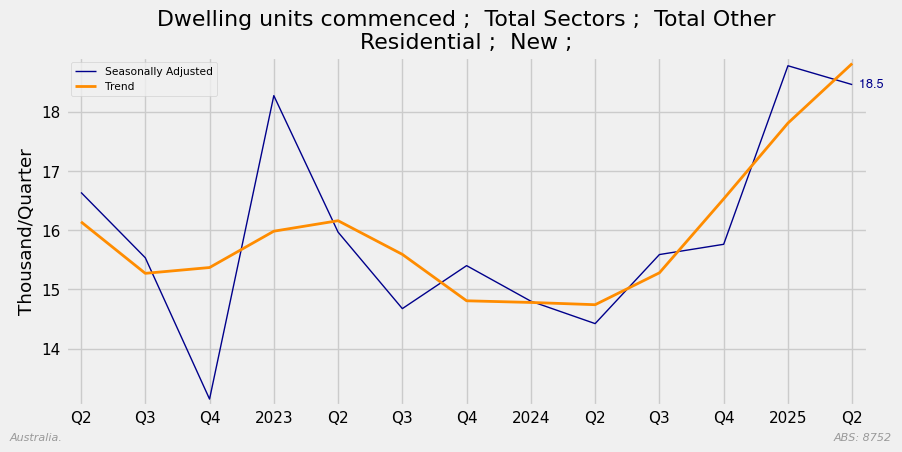

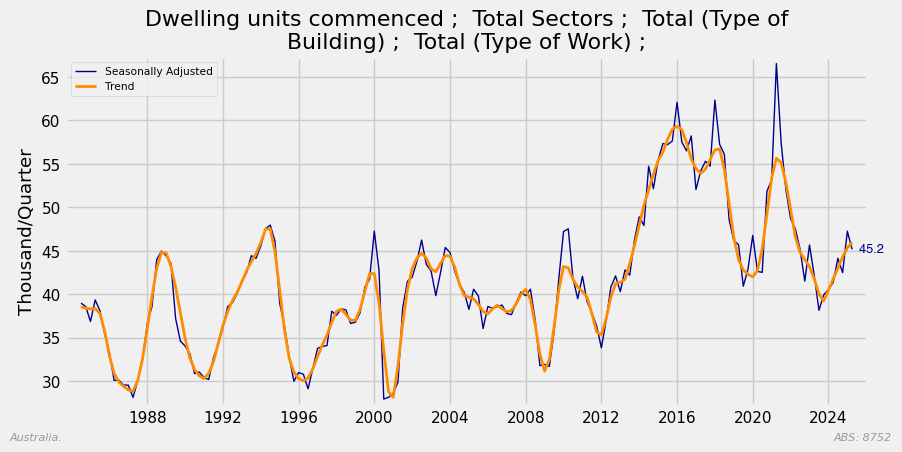

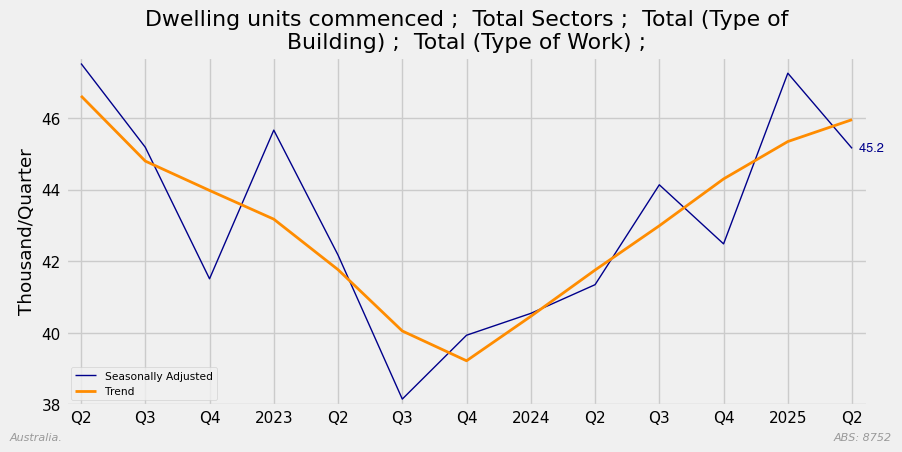

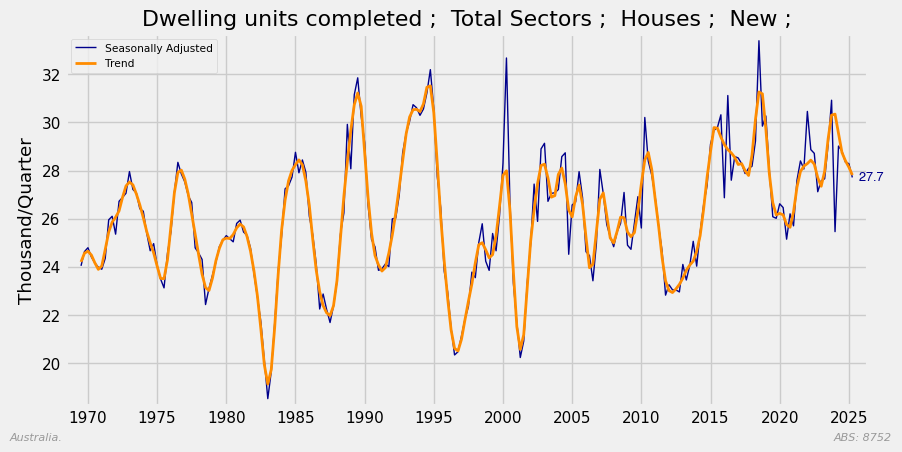

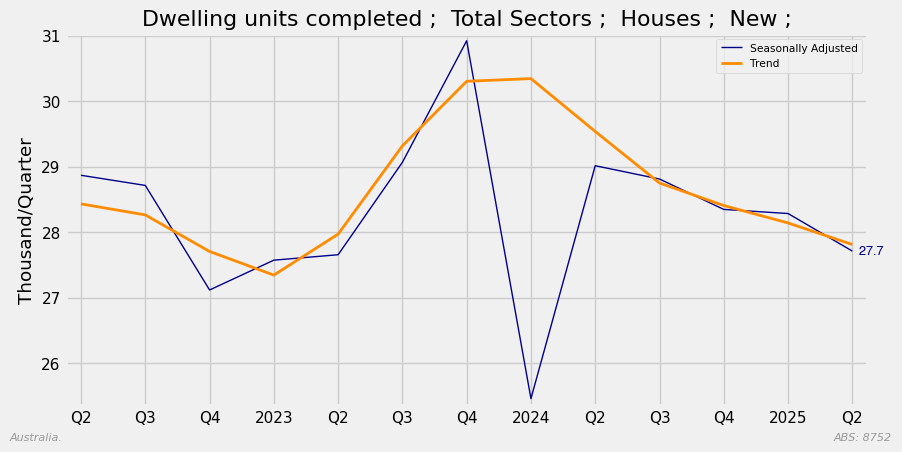

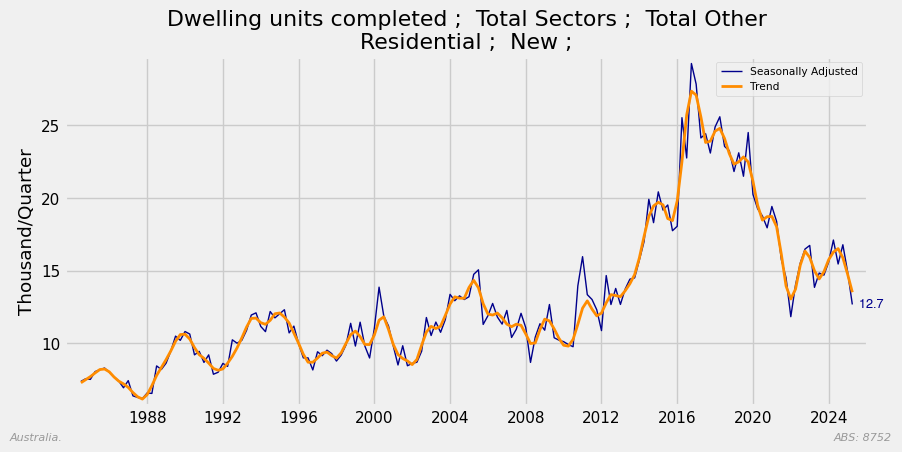

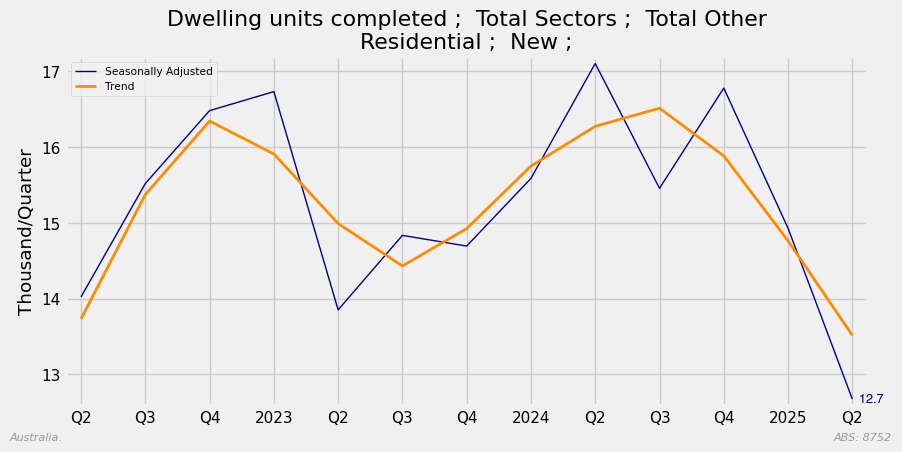

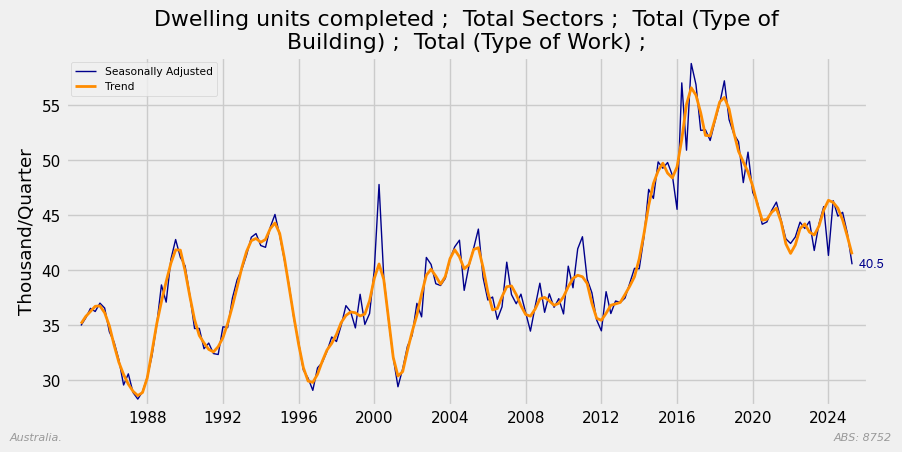

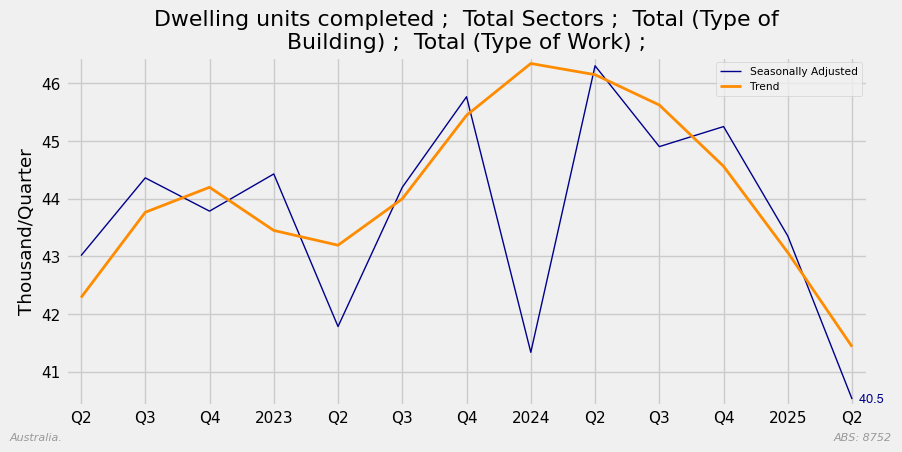

Nothing selected?
Nothing selected?


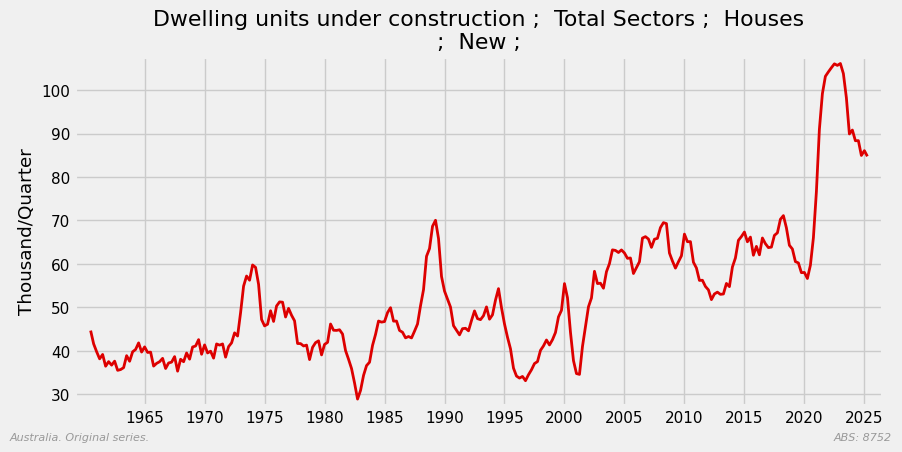

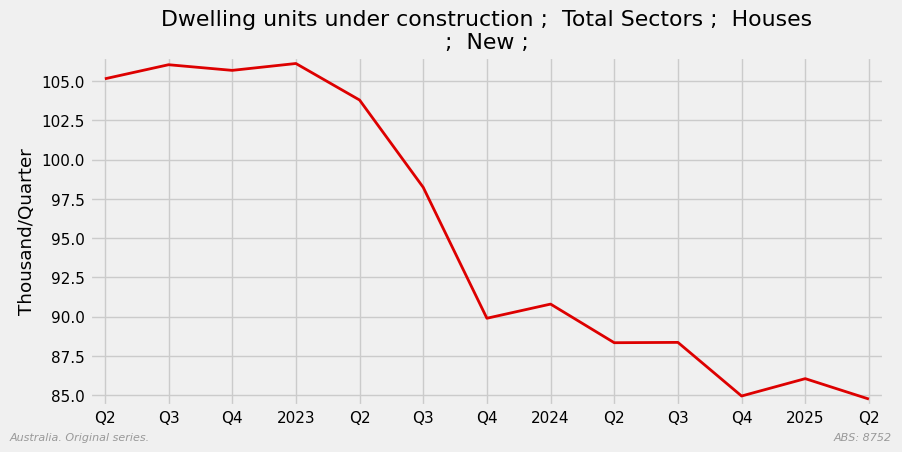

Nothing selected?
Nothing selected?


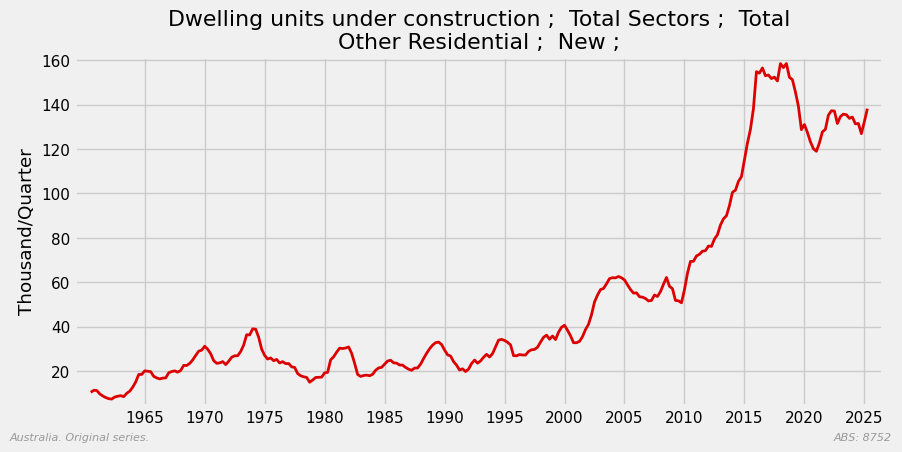

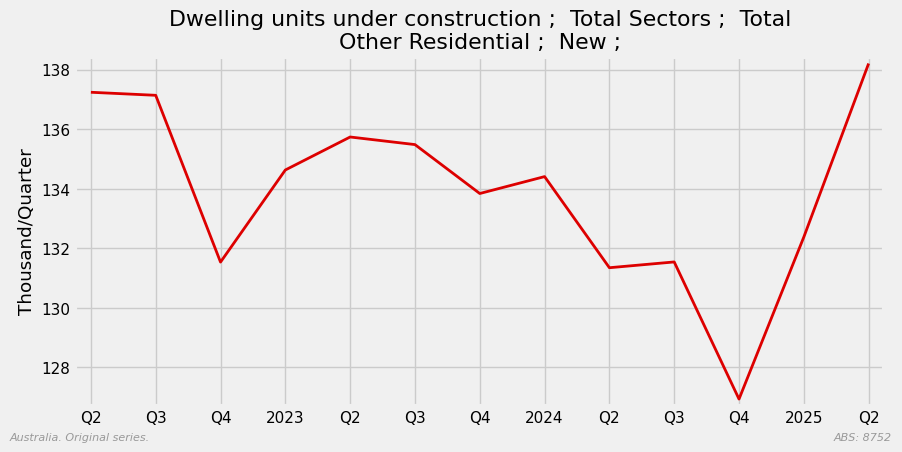

Nothing selected?
Nothing selected?


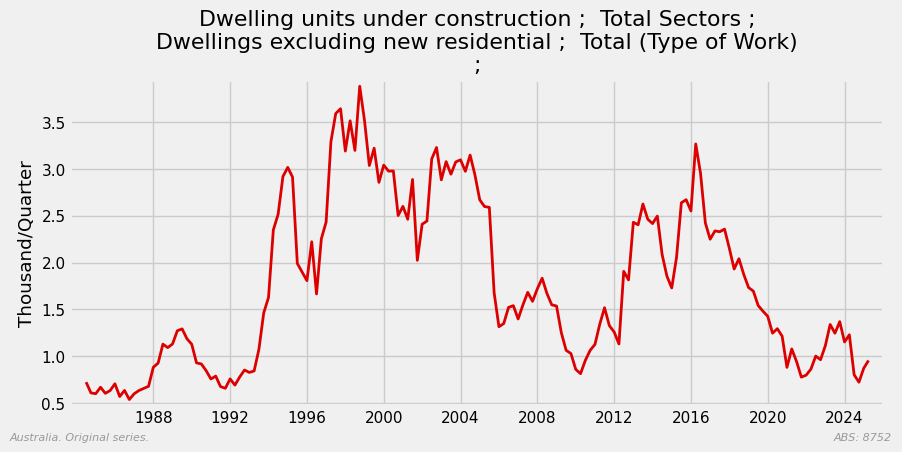

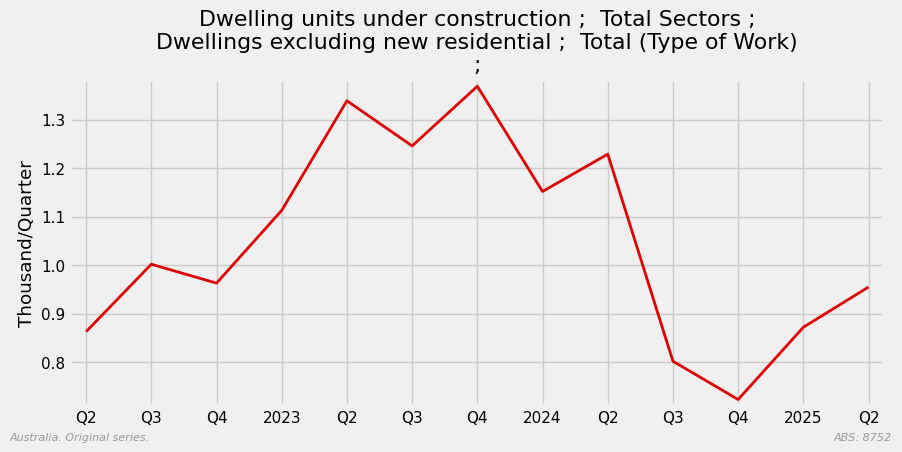

Nothing selected?
Nothing selected?


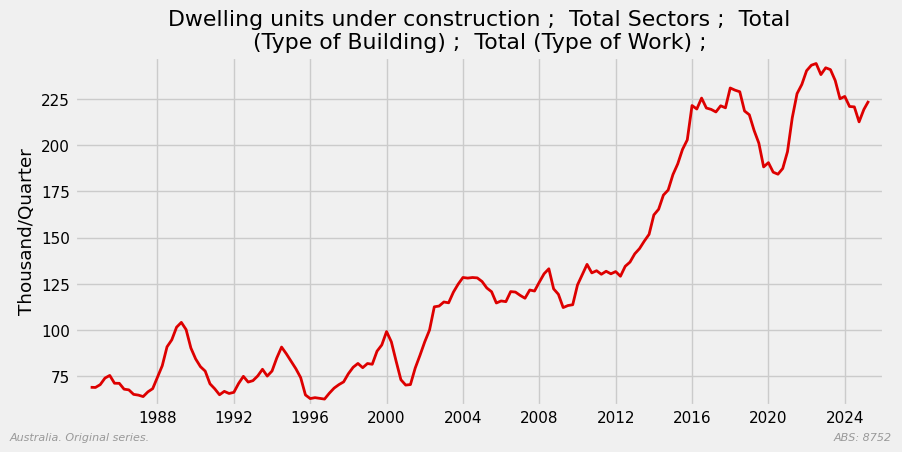

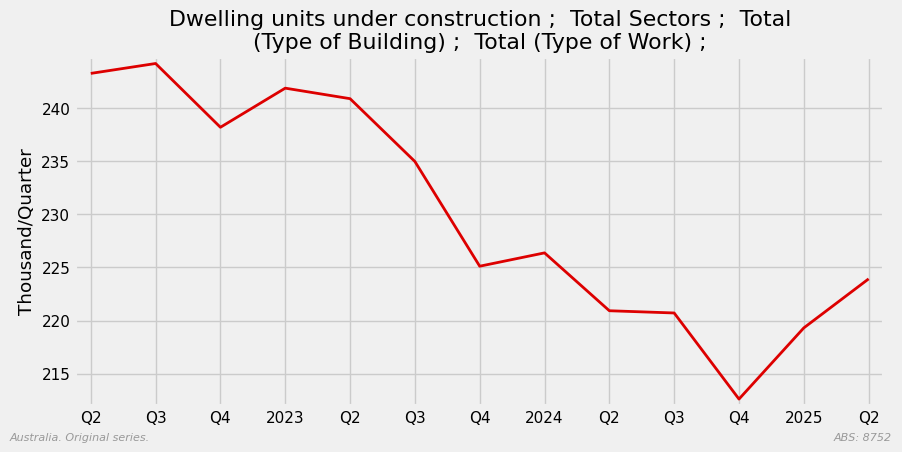

Nothing selected?
Nothing selected?


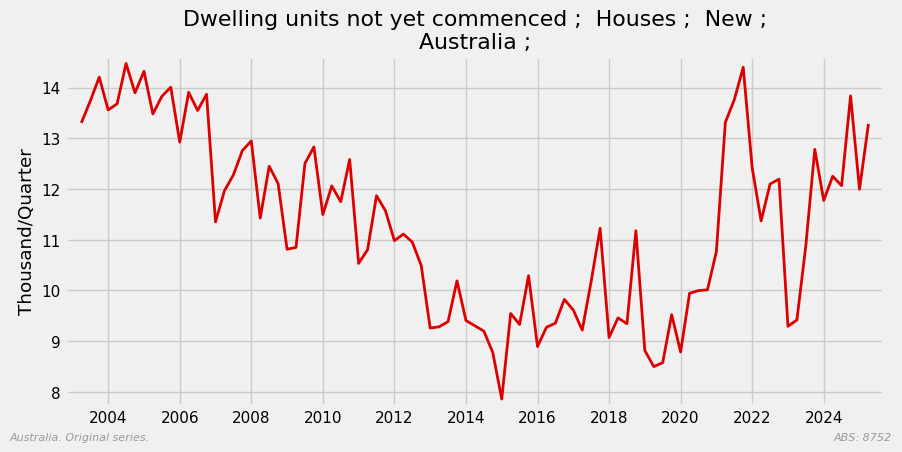

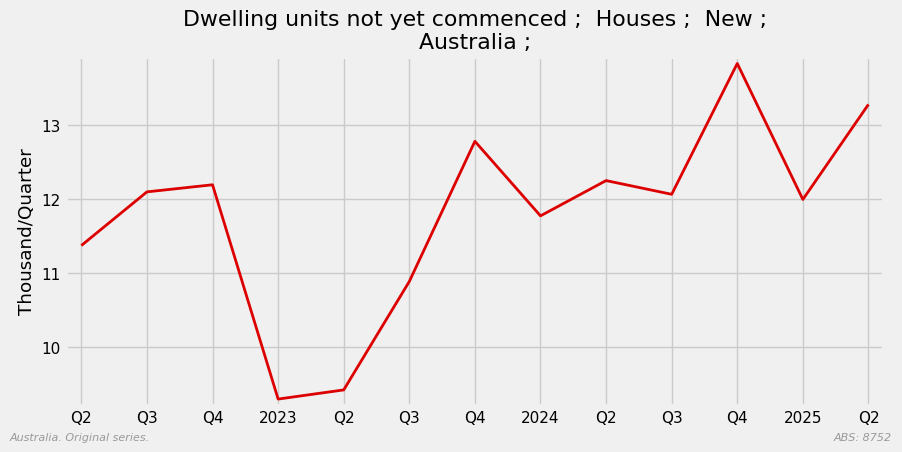

Nothing selected?
Nothing selected?


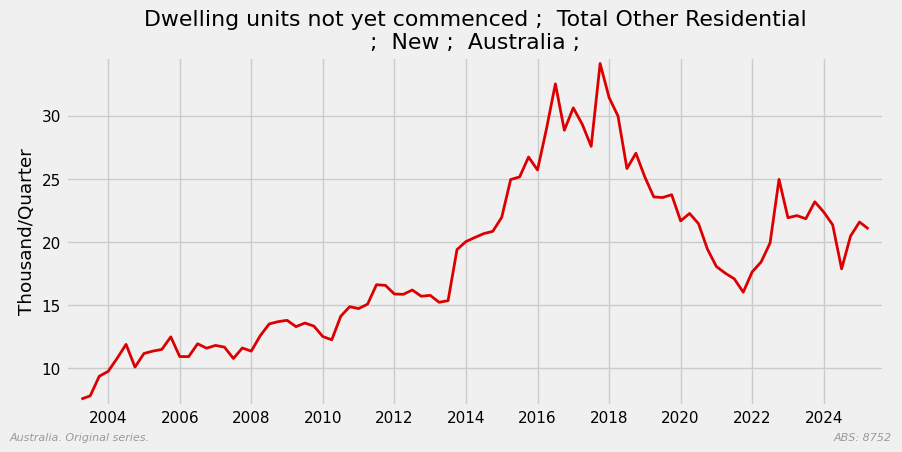

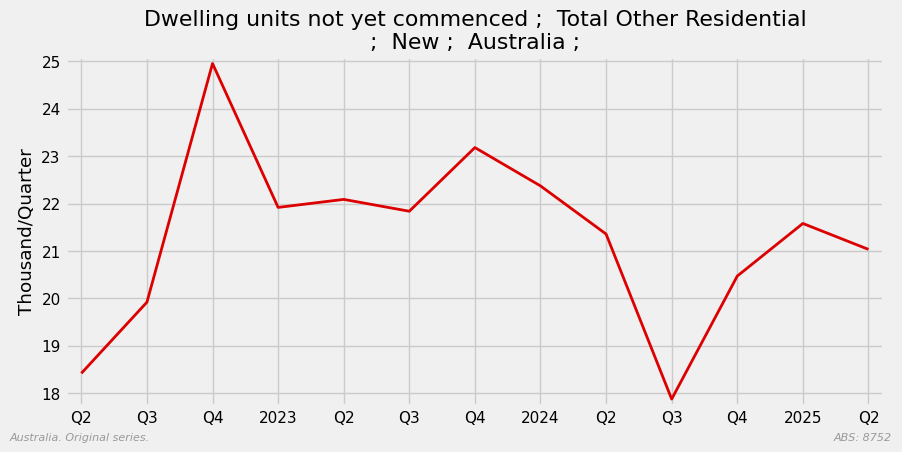

Nothing selected?
Nothing selected?


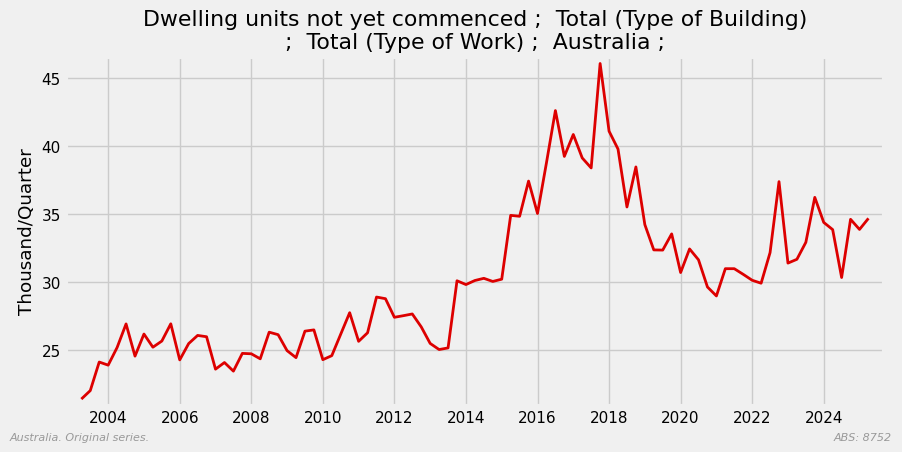

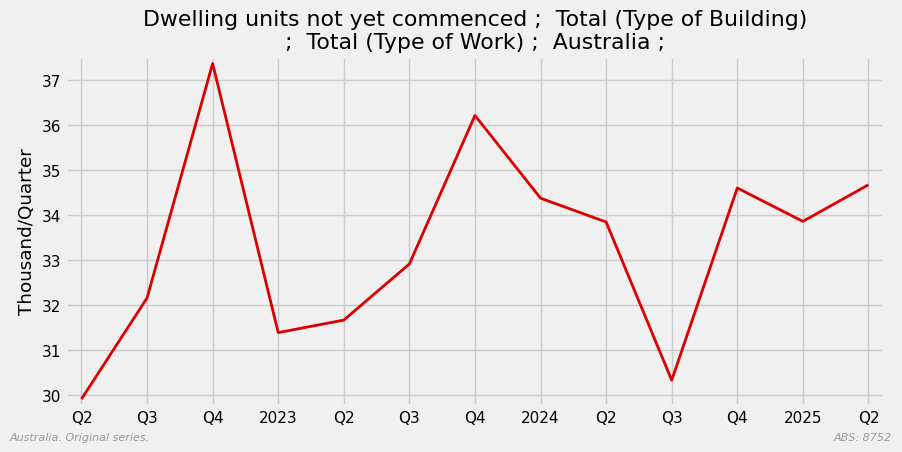

In [3]:
def plot_headline() -> None:
    """Plot headline series for the building activity data."""
    # pylint: disable=line-too-long

    wanted = [
        # table, did
        ["87520033", "Dwelling units commenced ;  Total Sectors ;  Houses ;  New ;"],
        [
            "87520033",
            "Dwelling units commenced ;  Total Sectors ;  Total Other Residential ;  New ;",
        ],
        [
            "87520033",
            "Dwelling units commenced ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;",
        ],
        ["87520037", "Dwelling units completed ;  Total Sectors ;  Houses ;  New ;"],
        [
            "87520037",
            "Dwelling units completed ;  Total Sectors ;  Total Other Residential ;  New ;",
        ],
        [
            "87520037",
            "Dwelling units completed ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;",
        ],
        # this next block will generate "Nothing selected" errors (as there is no SeasAdj or Trend data for these series)
        [
            "87520076",
            "Dwelling units under construction ;  Total Sectors ;  Houses ;  New ;",
        ],
        [
            "87520076",
            "Dwelling units under construction ;  Total Sectors ;  Total Other Residential ;  New ;",
        ],
        [
            "87520076",
            "Dwelling units under construction ;  Total Sectors ;  Dwellings excluding new residential ;  Total (Type of Work) ;",
        ],
        [
            "87520076",
            "Dwelling units under construction ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;",
        ],
        [
            "87520080",
            "Dwelling units not yet commenced ;  Houses ;  New ;  Australia ;",
        ],
        [
            "87520080",
            "Dwelling units not yet commenced ;  Total Other Residential ;  New ;  Australia ;",
        ],
        [
            "87520080",
            "Dwelling units not yet commenced ;  Total (Type of Building) ;  Total (Type of Work) ;  Australia ;",
        ],
    ]

    for table, did in wanted:
        f_dict = {}
        for stype in "Seasonally Adjusted", "Trend", "Original":
            search = {
                table: mc.table,
                did: mc.did,
                stype: mc.stype,
            }
            try:
                _t, sid, u = ra.find_abs_id(meta, search)
                f_dict[stype] = abs_dict[table][sid]
            except ValueError:
                continue
        found = pd.DataFrame(f_dict).sort_index()
        found, units = ra.recalibrate(found, u)

        if "Seasonally Adjusted" in f_dict and "Trend" in f_dict:
            if "Original" in f_dict:
                found = found.drop("Original", axis=1)
            multi_start(
                found,
                function=seastrend_plot_finalise,
                starts=plot_times,
                title=textwrap.fill(did, 60),
                lfooter="Australia. ",
                rfooter=f"ABS: {table[:4]}",
                ylabel=f"{units}/Quarter",
                show=SHOW,
                file_type=FILE_TYPE,
            )

        elif "Original" in f_dict:
            multi_start(
                found["Original"],
                function=line_plot_finalise,
                starts=plot_times,
                title=textwrap.fill(did, 60),
                lfooter="Australia. Original series. ",
                rfooter=f"ABS: {table[:4]}",
                ylabel=f"{units}/Quarter",
                width=2,
                show=SHOW,
                file_type=FILE_TYPE,
            )


plot_headline()

## building cycle

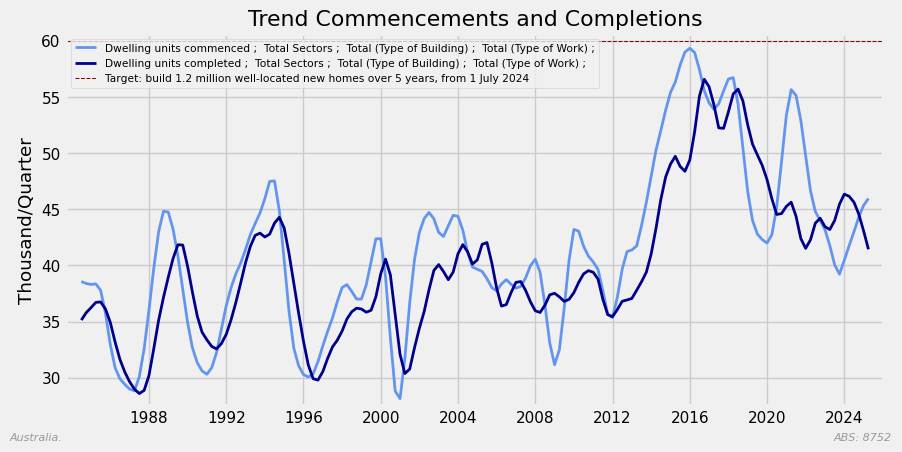

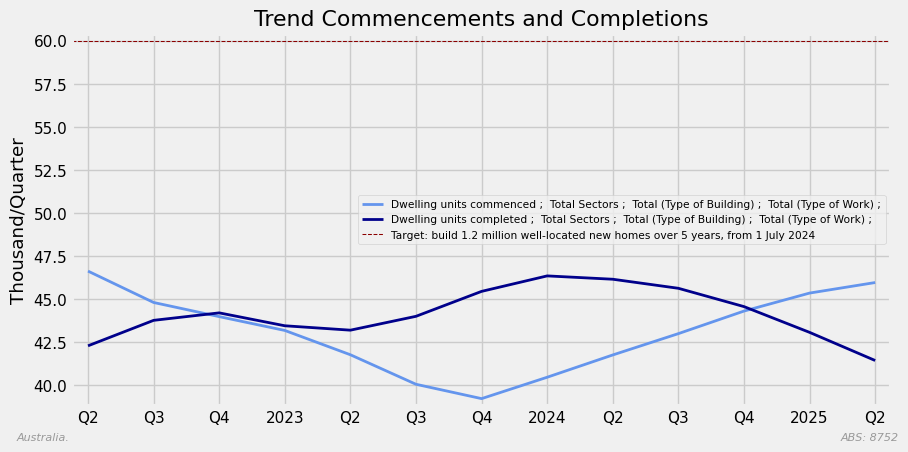

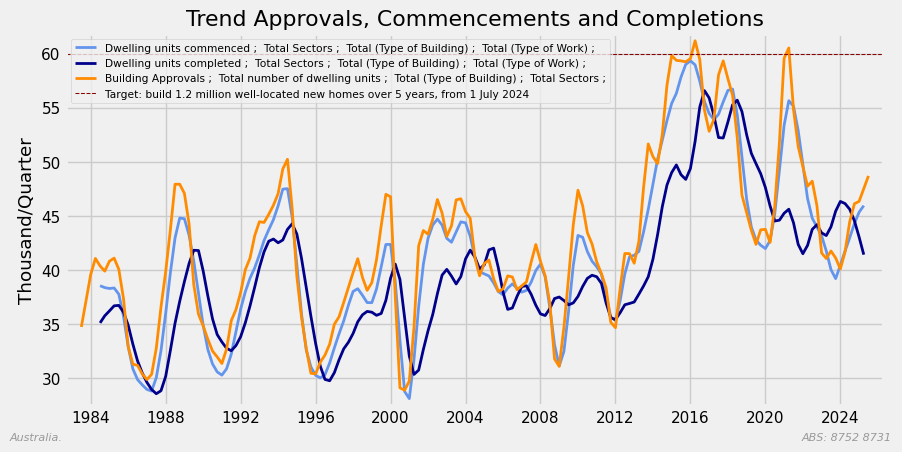

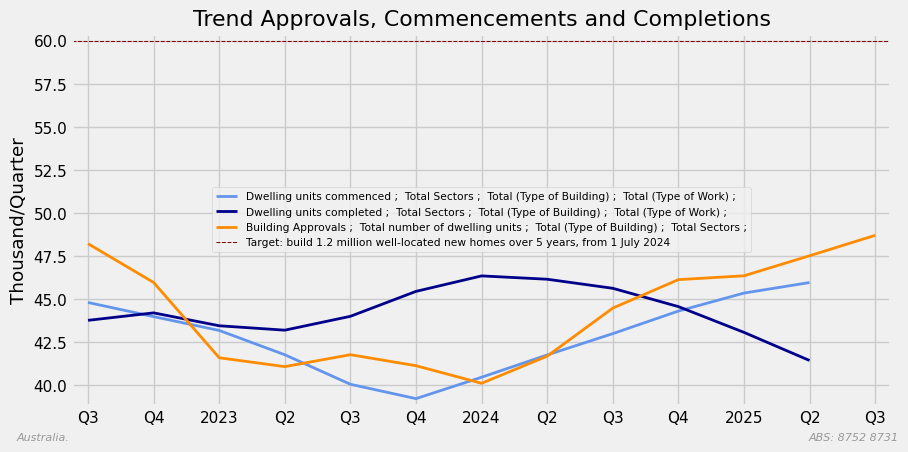

In [4]:
def building_cycle():
    """plot the building cycle."""
    # pylint: disable=line-too-long

    wanted = (
        (
            "87520033",
            "Dwelling units commenced ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;",
        ),
        (
            "87520037",
            "Dwelling units completed ;  Total Sectors ;  Total (Type of Building) ;  Total (Type of Work) ;",
        ),
    )

    common_line_plot = {
        # common arguments for the line_plot function
        "starts": plot_times,
        "function": line_plot_finalise,
        "width": 2,
        "color": ["cornflowerblue", "darkblue", "darkorange"],
        "axhline": {
            "y": 60,
            "label": "Target: build 1.2 million well-located new homes over 5 years, from 1 July 2024",
            "color": "darkred",
            "linestyle": "--",
            "lw": 0.75,
        },
        "legend": {"loc": "best", "fontsize": "x-small"},
        "lfooter": "Australia. ",
        "file_type": FILE_TYPE,
        "show": SHOW,
    }

    f_dict = {}
    for table, did in wanted:
        search = {
            table: mc.table,
            did: mc.did,
            "Trend": mc.stype,
        }
        _table, sid, units = ra.find_abs_id(meta, search)
        f_dict[did] = abs_dict[table][sid]
    found1 = pd.DataFrame(f_dict).sort_index()

    found1, units = ra.recalibrate(found1, units)
    multi_start(
        found1,
        title="Trend Commencements and Completions",
        rfooter=f"ABS: {table[:4]}",
        ylabel=f"{units}/Quarter",
        **common_line_plot,
    )

    # now add in the trend building approvals on a quarterly sum basis
    cat, sid = "8731.0", "A422072L"  # trend approvals, all sectors
    ta, ta_meta = ra.read_abs_series("8731.0", sid, single_excel_only="8731006")
    f_dict["Building Approvals ;  " + ta_meta.loc[sid, mc.did]] = ra.monthly_to_qtly(
        ta["A422072L"], f="sum"
    )
    found2 = pd.DataFrame(f_dict).sort_index()
    found2, units = ra.recalibrate(found2, ta_meta.loc[sid, mc.unit])
    multi_start(
        found2,
        title="Trend Approvals, Commencements and Completions",
        rfooter=f"ABS: {table[:4]} {cat[:4]}",
        ylabel=f"{units}/Quarter",
        **common_line_plot,
    )


building_cycle()

## Finished

In [5]:
# watermark
%load_ext watermark
%watermark -u -t -d --iversions --watermark --machine --python --conda

Last updated: 2025-11-03 11:46:58

Python implementation: CPython
Python version       : 3.14.0
IPython version      : 9.6.0

conda environment: n/a

Compiler    : Clang 20.1.4 
OS          : Darwin
Release     : 25.0.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

mgplot : 0.2.12
pandas : 2.3.3
readabs: 0.1.4

Watermark: 2.5.0



In [6]:
print("Finished")

Finished
